In [1]:
from os import walk
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import argparse
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix

In [2]:
tf.debugging.set_log_device_placement(False) 

## Defining Folders and Assiging Classes

### Reading Images from Folders and Reporting the Number of Images

In [34]:
# The original images were classified in the folder: random-lattices
# The splitted datasets (random shuffle) are saved in the folder: random-lattice-split

folder_path = os.path.join(os.getcwd(), "random-lattices")
folder_dest = os.path.join(os.getcwd(), "random-lattices-split")

# Set the roots for train and validation folders
train_folder = os.path.join(folder_dest, "train_set")
valid_folder = os.path.join(folder_dest, "valid_set")

# Calculate the total number of classes and images
classes = os.listdir(folder_path)

tot_number_images = 0
train_size = 0
valid_size = 0

for each_class in classes:    
    tot_number_images += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(folder_path, each_class)))))

    # Get sizes of train and valid datasets
    train_size += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(train_folder, each_class)))))
    valid_size += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(valid_folder, each_class)))))

print(f"Total number of classes is {len(classes)} and total number of images is  {tot_number_images}")

#Calculate the percentage of the images in train_set with respect to total number of images
sum_train_set = sum([len(files) for _, _, files in os.walk(train_folder)])

print(f"Total images in train set in percentage is {sum_train_set*100 / tot_number_images: .2f}")
print(f"Size of the train set is  {train_size} and valid set is  {valid_size}")

Total number of classes is 13 and total number of images is  3064
Total images in train set in percentage is  69.78
Size of the train set is  2138 and valid set is  926


the size of the image is  (1000, 1000)
the maximum value in image is  255


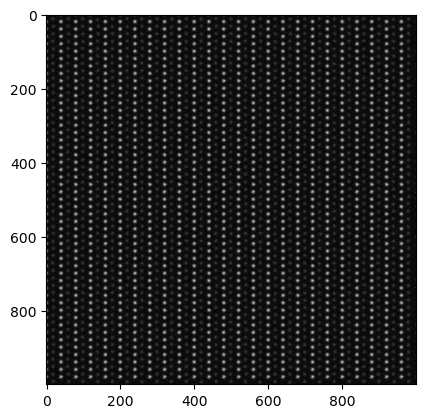

In [62]:
# look at
def random_image(path):
    """
    A function to load a random image from train folder and visualize the image
    """
    path=glob(train_folder+"/*/*.png")
    a=image.load_img(np.random.choice(path))
    plt.imshow(a)
    print("the size of the image is ",a.size)
    print("the maximum value in image is ",np.max(a))
    plt.show()

random_image(glob(train_folder+"/*/*.png"))

## Define some image parameters for the Model Training

In [36]:
dim1=[]
dim2=[]

for cs in os.listdir(train_folder):
    cs_path = os.path.join(train_folder, cs)
    for image_filename in os.listdir(cs_path):
        image_path = os.path.join(cs_path, image_filename)
        with Image.open(image_path) as img:    # Image.open from PIL library
            width, height = img.size
            dim1.append(width)
            dim2.append(height)
            
# We can choose the minimum image size or the average image size depends on available resources for computation
image_shape=(int(np.min(dim1)), int(np.min(dim2)))
#image_shape=(int(np.average(dim1)), int(np.average(dim2)))

image_shape

(600, 600)

**Define batch size and epochs**

In [37]:
#Either choose the image size from the found average/minimum image size or choose it manually 

#image_size=[image_shape[0], image_shape[1]]
image_size=[400, 400]
batch_size=16
epochs=15

## Define Generators

 Here, we define the main generators for image augmentation using ImageDataGenerator. It is recommended to reate a test dataset like 10% of the data and valid dataset like 20% of the data. I use valid dataset as test dataset which is not correct. So, for real project, I do recommend people to have train, valid and test datasets.

In [38]:
#Define general arguments for the image augmentation
data_gen_args = dict(
                    rescale = 1 / 255.0,
                    preprocessing_function = preprocess_input
                    )
#Define Train Generator
print("number of images and classes for train generator is: ")
train_data_gen = ImageDataGenerator(**data_gen_args, rotation_range = 30).flow_from_directory(train_folder, 
                                                                                             shuffle = True,
                                                                                             target_size = image_size,
                                                                                             batch_size = batch_size)
#Define Valid Generator
print("number of images and classes for valid generator is: ")
valid_data_gen = ImageDataGenerator(**data_gen_args, rotation_range = False).flow_from_directory(valid_folder, 
                                                                                                shuffle = False,
                                                                                                target_size = image_size,
                                                                                                batch_size = batch_size)

print("")
print(f"The image shape is {train_data_gen.image_shape} and the image type is {train_data_gen.dtype}")

number of images and classes for train generator is: 
Found 2138 images belonging to 13 classes.
number of images and classes for valid generator is: 
Found 926 images belonging to 13 classes.

The image shape is (400, 400, 3) and the image type is float32


In [41]:
#Alternative for the code above
class_indices= train_data_gen.class_indices
labels = dict((u,v) for v,u in class_indices.items())
labels

{0: 'cubic_bcc',
 1: 'cubic_bcc_2atom',
 2: 'hexagon',
 3: 'hexagon_2atom',
 4: 'ortho_body_centered',
 5: 'ortho_face_centered',
 6: 'teteragonal_body_center',
 7: 'teteragonal_c',
 8: 'teteragonal_face',
 9: 'teteragonal_face_bcc',
 10: 'teteragonal_face_bcc_2atom',
 11: 'teteragonal_reg_2atom',
 12: 'triclinic_rhomboh'}

In [ ]:
#train_ds=tf.data.Dataset.from_generator(lambda: train_gen_vgg, output_types=train_gen_vgg.dtype)
#valid_ds=tf.data.Dataset.from_generator(lambda: valid_gen_vgg, output_types=valid_gen_vgg.dtype)

## Load VGG, Define Dense Layer and Execute Model

In [47]:
# Define the available model options and get user input
options = ["full_cnn", "cnn_5_removed"]

model_name = input(f"please select a model from the list {options} \n")
title = input(f"Please choose a title for files to be save later \n")

#Load VGG parameters
vgg = VGG16(
            input_shape = image_size + [3], 
            weights = "imagenet",
            include_top = False
           )

for layer in vgg.layers:
    layer.trainable=False 
    
def get_num_layers(vgg, model_name):
    """ 
    This function allows one to use all layers of VGG model or drop last layer or even more. 
    I assume that I need full layers or I like to drop the last layer (5th one) 
    """
    if model_name == "full_cnn":
        
        #Define the Dense layers
        x=Flatten()(vgg.output)
        x=Dense(2048, activation="relu")(x)
        x=Dense(1024, activation="relu")(x)
        x=Dropout(0.2)(x)
        prediction = Dense(len(classes), activation = "softmax")(x)
        
    elif model_name == "cnn_5_removed":
        
        #removing the layer 5 of the vgg layers
        layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
        output_4 = layer_dict["block4_pool"].output
        vgg_2 = tf.keras.Model(inputs = vgg.input, outputs = output_4)
        x = Flatten()(vgg_2.output)  
        x = Dense(1024, activation = "relu")(x)
        #x = Dense(1024, activation = "relu")(x)
        #x = Dropout(0.2)(x)
        prediction = Dense(len(classes), activation = "softmax")(x)
        
    else:
        raise ValueError("Invalid Model Architucture")
    return prediction

#Define the prediction 
prediction = get_num_layers(vgg, model_name)

#Pass the parameters, inputs and outputs to the VGG model
model_vgg = Model(inputs = vgg.input, outputs = prediction)

please select a model from the list ['full_cnn', 'cnn_5_removed'] 
full_cnn
Please choose a title for files to be save later 
full_cnn_2048


In [48]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0   

In [49]:
#Compile the model
model_vgg.compile(
                  loss = "categorical_crossentropy", 
                  optimizer="adam", 
                  metrics = ["accuracy"])

summary_model_path = os.path.join(folder_dest, f"summary_{title}.h5")

model_vgg.save(summary_model_path)

checkpoint_filepath = os.path.join(folder_dest, f"summary_{title}.h5")

checkpoint = ModelCheckpoint(
                             filepath=checkpoint_filepath, 
                             monitor='val_accuracy', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only = True, 
                             mode='max')

early = EarlyStopping(
                      monitor='loss', 
                      min_delta=0, 
                      patience=3,
                      verbose=0, 
                      restore_best_weights = True)

In [50]:
start=time.time()

random_lattice_vgg = model_vgg.fit(
    train_data_gen,
    validation_data = valid_data_gen,
    batch_size=batch_size, 
    epochs = epochs,
    validation_steps = valid_size//batch_size,
    steps_per_epoch = train_size//batch_size,
    callbacks = [checkpoint, early])

end=time.time()
total_time=(end-start)/60
print("total time in min is :", total_time)

Epoch 1/15
133/133 [==============================] - 78s 583ms/step - loss: 3.4612 - accuracy: 0.4105 - val_loss: 1.2298 - val_accuracy: 0.5219
Epoch 2/15
133/133 [==============================] - 76s 573ms/step - loss: 1.0938 - accuracy: 0.5782 - val_loss: 1.0761 - val_accuracy: 0.5921
Epoch 3/15
133/133 [==============================] - 79s 596ms/step - loss: 0.8814 - accuracy: 0.6635 - val_loss: 0.7164 - val_accuracy: 0.7127
Epoch 4/15
133/133 [==============================] - 77s 576ms/step - loss: 0.7395 - accuracy: 0.7026 - val_loss: 0.7593 - val_accuracy: 0.6754
Epoch 5/15
133/133 [==============================] - 79s 591ms/step - loss: 0.4560 - accuracy: 0.7926 - val_loss: 0.7067 - val_accuracy: 0.7314
Epoch 6/15
133/133 [==============================] - 78s 588ms/step - loss: 0.4489 - accuracy: 0.8054 - val_loss: 0.7583 - val_accuracy: 0.7270
Epoch 7/15
133/133 [==============================] - 77s 579ms/step - loss: 0.5568 - accuracy: 0.7813 - val_loss: 0.7794 - val_ac

In [51]:
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}"))
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}.h5"))

INFO:tensorflow:Assets written to: C:\Ali\ETH\ScopeM\Projects\2884_Kim_Minsoo\polarization\BTO15\Simulation\random-lattices-split\entire_model_full_cnn_2048\assets


## Plot Metrics and Confusion Matrix

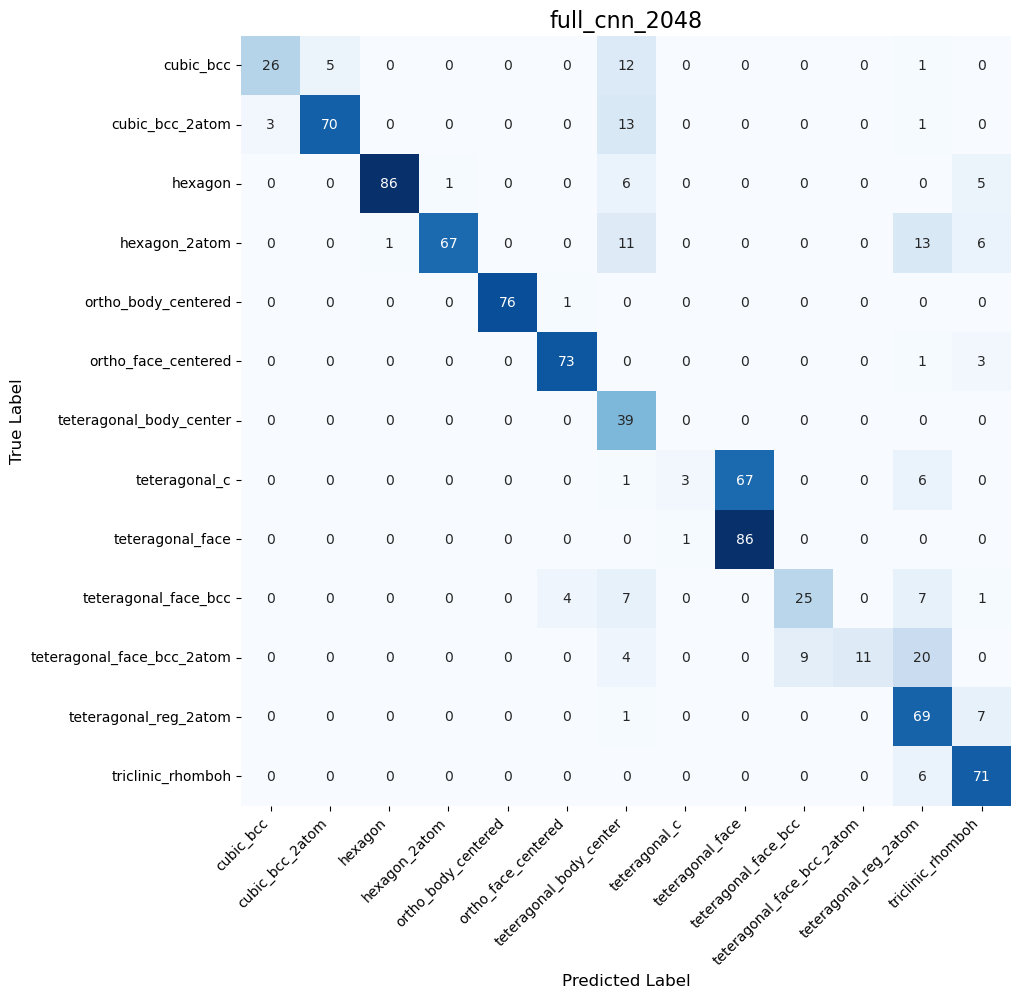

In [52]:
#Plot confusion matrix for test dataset if available, otherwise on validation dataset

#First, get the values of the predicted labels (classes)
predicted_classes = np.argmax(model_vgg.predict(valid_data_gen), axis=1)

# Get the names of the classes and the true labels
class_names  = valid_data_gen.class_indices.keys()
true_classes = valid_data_gen.classes

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    """ A function to get predicted and true y labels and plot a heatmap (from seaborn) of true prediction """
    cm = confusion_matrix(y_true, y_pred)
    heatmap(
            cm, 
            annot = True, 
            square= True, 
            xticklabels = class_names, 
            yticklabels = class_names,
            fmt  = "d", 
            cmap = plt.cm.Blues,
            cbar = False, 
            ax = ax
            )
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_xlabel("Predicted Label", fontsize = 12)

fig, ax1 = plt.subplots(1, 1, figsize = (15, 10))
plot_heatmap(true_classes, predicted_classes, class_names, ax1, title=title)    
plt.savefig(folder_dest + title + "_confusion_plot.png", bbox_inches = "tight")

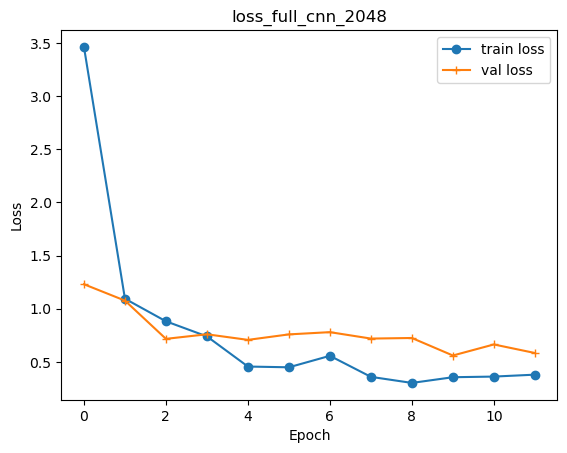

In [53]:
# Plot Loss
history = random_lattice_vgg.history
plt.plot(history["loss"],   label = "train loss", marker = "o")
plt.plot(history["val_loss"], label = "val loss", marker = "+")
plt.legend()
plt.title(f"loss_{title}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(folder_dest + title + "_loss.png", dpi=300, bbox_inches='tight')
plt.show()

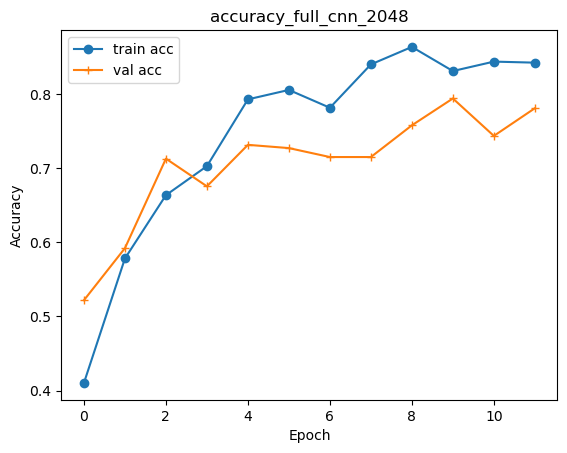

In [54]:
# Plot Accuracy
plt.plot(history["accuracy"],   label = "train acc", marker = "o")
plt.plot(history["val_accuracy"], label = "val acc", marker = "+")
plt.legend()
plt.title(f"accuracy_{title}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(folder_dest+title+"_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
#Calculate the score of train and valid sets and make a table
score_valid=model_vgg.evaluate(valid_data_gen, batch_size = batch_size, return_dict=True)
score_train=model_vgg.evaluate(train_data_gen, batch_size = batch_size, return_dict=True)

score_eval = pd.DataFrame({"score_valid" : score_valid, "score_train": score_train})
score_eval.to_csv(folder_dest + f"score evaluation {title}")
score_eval

134/134 [==============================] - 69s 516ms/step - loss: 0.2809 - accuracy: 0.8676


,score_valid,score_train
loss,0.719483,0.280873
accuracy,0.758099,0.867633


In [56]:
def get_confusion_matrix(data_path, N):
    """ A function to get confusion matrix"""

    data_gen = ImageDataGenerator(**data_gen_args).flow_from_directory(data_path, 
                                                                        shuffle = False,
                                                                        target_size = image_size,
                                                                        batch_size = batch_size)
    predicted_list = []
    true_list = []
    #we can iterate over all batches in data_gen, and access to all images/labels per batch (train_size or valid_size)
    for i in range(data_gen.samples // batch_size+1): 
        
        batch_image, batch_label = data_gen[i]  #access to all iamges/labels per batch
       
        pred_label = model_vgg.predict(batch_image)
        predicted_list.append(pred_label)
        #since the labels are one hot encoded, we need integer for confusion matrix
        true_label = np.argmax(batch_label, axis =1)
        true_list.append(true_label)

    pred_label = np.concatenate(predicted_list, axis = 0)
    pred_label = np.argmax(pred_label, axis =1)

    true_label = np.concatenate(true_list, axis = 0)
        
    cm = confusion_matrix(true_label, pred_label)
    return cm

train_cm = get_confusion_matrix(train_folder, train_size)
print("Confusion matrix for train dataset \n", train_cm) 
print("")
valid_cm = get_confusion_matrix(valid_folder, valid_size)
print("Confusion matrix for valid dataset \n", valid_cm)    

Found 2138 images belonging to 13 classes.
Confusion matrix for train dataset 
 [[ 70  11   0   0   0   0  18   0   0   0   0   1   0]
 [ 14 157   0   0   0   0  27   0   0   0   0   3   0]
 [  0   0 186   8   0   0  12   0   0   0   0   0  20]
 [  0   0   0 161   0   0  25   0   0   0   0  28  12]
 [  0   0   0   0 178   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0 175   0   0   0   0   0   1   3]
 [  0   0   0   0   0   0  89   0   0   0   0   0   0]
 [  0   0   0   0   0   0  10  16 148   0   0   5   0]
 [  0   0   0   0   0   0   0   3 198   0   0   0   0]
 [  0   0   0   0   0  19  22   0   0  46   0  12   1]
 [  0   0   0   0   0   0  10   0   0  29  25  36   0]
 [  0   0   0   0   0   0   0   0   1   0   0 173   5]
 [  0   0   0   0   0   1   0   0   0   0   0  11 167]]

Found 926 images belonging to 13 classes.
Confusion matrix for valid dataset 
 [[26  5  0  0  0  0 12  0  0  0  0  1  0]
 [ 3 70  0  0  0  0 13  0  0  0  0  1  0]
 [ 0  0 86  1  0  0  6  0  0  0  0  0  5

In [57]:
def get_confusion_matrix(data_path, N):
    """ A function to get confusion matrix"""
    data_gen = ImageDataGenerator(**data_gen_args).flow_from_directory(data_path, shuffle = False,
                                                                                             target_size = image_size,
                                                                                             batch_size = batch_size)
    true_label = np.concatenate([data_gen.next()[1] for i in range(data_gen.samples // batch_size+1)])
    true_label = np.argmax(true_label, axis = 1)

    pred_label = model_vgg.predict(data_gen)
    pred_label = np.argmax(pred_label, axis = 1)
    
    cm = confusion_matrix(true_label, pred_label)
    return cm


train_cm = get_confusion_matrix(train_folder, train_size)
print("Confusion matrix for train dataset", train_cm) 
print("")
valid_cm = get_confusion_matrix(valid_folder, valid_size)
print("Confusion matrix for valid dataset", valid_cm)    


Found 2138 images belonging to 13 classes.
Confusion matrix for train dataset [[ 70  11   0   0   0   0  18   0   0   0   0   1   0]
 [ 14 157   0   0   0   0  27   0   0   0   0   3   0]
 [  0   0 186   8   0   0  12   0   0   0   0   0  20]
 [  0   0   0 161   0   0  25   0   0   0   0  28  12]
 [  0   0   0   0 178   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0 175   0   0   0   0   0   1   3]
 [  0   0   0   0   0   0  89   0   0   0   0   0   0]
 [  0   0   0   0   0   0  10  16 148   0   0   5   0]
 [  0   0   0   0   0   0   0   3 198   0   0   0   0]
 [  0   0   0   0   0  19  22   0   0  46   0  12   1]
 [  0   0   0   0   0   0  10   0   0  29  25  36   0]
 [  0   0   0   0   0   0   0   0   1   0   0 173   5]
 [  0   0   0   0   0   1   0   0   0   0   0  11 167]]

Found 926 images belonging to 13 classes.
Confusion matrix for valid dataset [[26  5  0  0  0  0 12  0  0  0  0  1  0]
 [ 3 70  0  0  0  0 13  0  0  0  0  1  0]
 [ 0  0 86  1  0  0  6  0  0  0  0  0  5]
 [

## Prediction

In [ ]:
from tensorflow.keras.models import load_model

def get_random_image (image_dir, image_size):
    """ A function to load and display a random image from a specified directory
        image_dir (str): e.g. train_folder, valid_folder etc
        image_size (list int): e.g. [600, 600] 
    """
    
    # Choose a random class (label) from available classes
    random_class=np.random.choice(os.listdir(image_dir))
    
    # Select a random image from chosen class
    random_img=np.random.choice(glob(os.path.join(image_dir, random_class, "*.png")))
    
    #Load and display image
    img=image.load_img((random_img), 
                       target_size = (image_size[0], image_size[1])
                      )
    plt.imshow(img)
    plt.show()
    
    #Convert the loaded image to a format which is suitable for the model
    img_array = image.img_to_array(img)
    img_array = img_array.reshape (1, *img_array.shape) / 255.0
    
    return img_array, random_class
   
def check_image(title, img_size):
    """ A function to load a saved model, select and display a random image, and predict its class """
    
    # Load a saved model
    model = load_model(os.path.join(folder_dest, f"entire_model_{title}")) 
    
    # Load and dispaly a random image
    img_array, random_class = get_random_image(train_folder, image_size)
    
    #Predict the class of the image
    output = np.argmax(model.class_indices(img_array), axis = -1)
    
    #Check if the predicted class is the same as the real class
    real_class_index = test_data_gen.class_indices[random_class]
    predicted_class_index = np.argmax(output)
    predicted_class= list(test_data_gen.class_indices.keys())[predicted_class_index]
          
    if predicted_class_index == real_class_index:
        print("real class and the predicted class are both ", random_class)
    else:
        print("real class is ", random_class," but predicted class is ", predicted_class )

In [ ]:
check_image(title, 700)

# Visualizing what convnets learn


In [ ]:
# load the model
model2 = VGG16()
# summarize filter shapes
for layer in model2.layers:

    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model2.layers[1].get_weights()
biases[0:9]

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filters.shape

In [ ]:
# plot  filters
filters, biases = model2.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 6, 1
for i in range(n_filters):
    
     # get the filter
    f = filters[:, :, :, i]
     # plot each channel separately
    for j in range(3):
        #specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

### How to Visualize Feature Maps

In [ ]:
# redefine model to output right after the first hidden layer
model2= VGG16(input_shape=image_size+[3], weights="imagenet", include_top=False)

model2 = Model(inputs=model2.inputs, outputs=model2.layers[16].output)
print(model2.output_names)

In [ ]:
os.makedirs(folder_dest+"/feature maps/",exist_ok=True )

In [ ]:
folder_map=folder_dest+"/feature maps"

# redefine model to output right after the first hidden layer
model2= VGG16(input_shape=image_size+[3], weights="imagenet", include_top=False)

model2 = Model(inputs=model2.inputs, outputs=model2.layers[17].output)
layer_title=model2.output_names

layer_title="".join(layer_title)

# load the image with the required shape, a random image from a random class

#random_class=np.random.choice(os.listdir(train_folder))
#random_image=np.random.choice(glob(train_folder+"/"+random_class+"/*.png"))

random_class= os.listdir(train_folder)[5]
random_image=glob(train_folder+"/"+random_class+"/*.png")[100]


image_class=random_class.split("\\")[-1]
image_title=random_image.split("\\")[-1]

img = image.load_img(random_image, target_size=(image_size[0], image_size[1]))

plt.imshow(img)
plt.title(f"random_image {image_title} from class {image_class}")
plt.savefig(folder_map+"/"+f"{layer_title} {image_title}.png")

img = image.img_to_array(img) # convert the image to an array
img = np.expand_dims(img, axis=0) # expand dimensions so that it represents a single 'sample'  (1, 600, 600, 3)
img = preprocess_input(img) # prepare the image (e.g. scale pixel values for the vgg)  max=145.061

# get feature map for first hidden layer
feature_maps = model2.predict(img)   #(1, 600, 600, 64)

# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(16,16))
square =4 
ix = 1
for _ in range(square):   #underscore is like iterator when the interator is not used in code
    
    #
     for _ in range(square):
        #
         # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{layer_title} and filter number {ix}")
         # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        
        
        ix += 1
      
plt.savefig(folder_map+"/"+f"{layer_title} {image_title} {square}.png")
#plt.title(f"{layer_title} and number of filters {square}")
#plt.suptitle(f"{layer_title} and number of filters {square}")

# show the figure
plt.show()